# First Test: Median filter with real data.

## DW (2015.11.23)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import medfilt
import gitInformation
from neo.io import NeuralynxIO
import quantities as pq

In [2]:
%matplotlib inline

In [3]:
gitInformation.printInformation()

Information about this notebook
Date: 2016-01-05
Python Version: 2.7.10 |Anaconda 2.3.0 (64-bit)| (default, May 28 2015, 16:44:52) [MSC v.1500 64 bit (AMD64)]
Git directory: C:\Users\Dominik\Documents\GitRep\kt-2015-DSPHandsOn\.git
Current git SHA: aa3853e0374225c26d947dd83698e78c9c013954
Remotes: fork, origin, 
Current branch: master
fork remote URL: http://github.com/dowa4213/kt-2015-DSPHandsOn.git
origin remote URL: https://github.com/ktakagaki/kt-2015-DSPHandsOn.git


### Figure 1. Real Data

In [4]:
cachedir = 'C:\\Users\\Dominik\\Documents\\GitRep\\kt-2015-DSPHandsOn\\MedianFilter\\Python\\07. Real Data'
NIO = NeuralynxIO(sessiondir = cachedir, cachedir = cachedir)
block = NIO.read_block(t_stops = 2500*pq.s,events=True)
seg = block.segments[0]
analogsignal = seg.analogsignalarrays[0]

C:\Anaconda\lib\site-packages\quantities-0.11.1-py2.7.egg\quantities\quantity.py:379: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [5]:
csc = analogsignal.magnitude

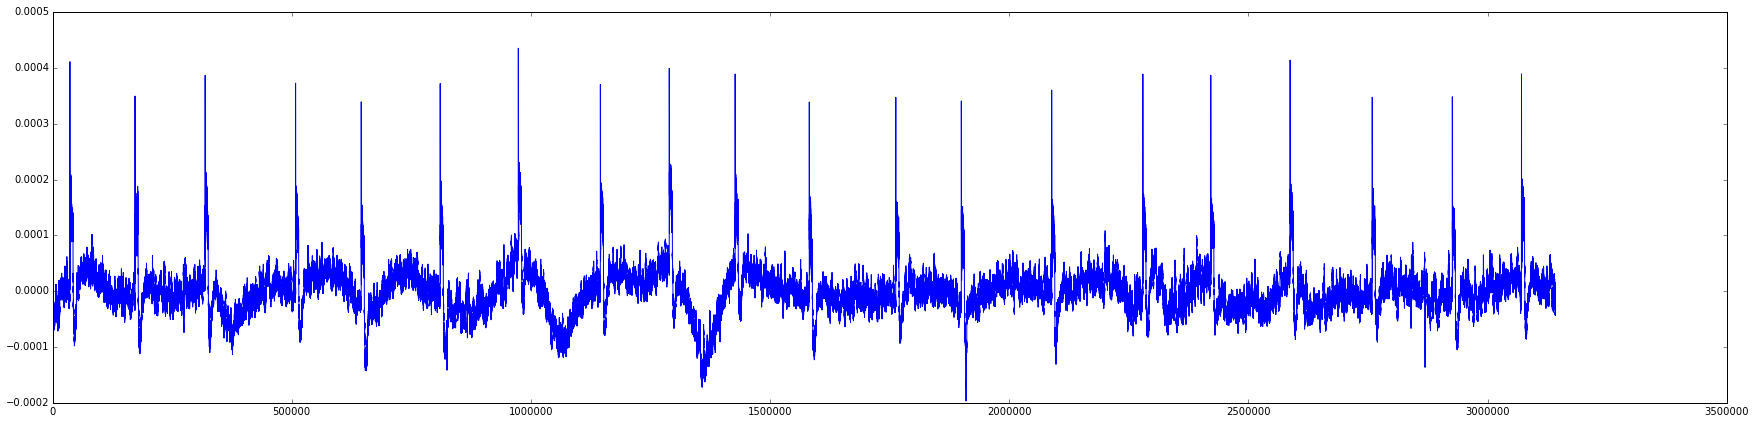

In [6]:
plt.figure(figsize=(30,7))
plt.plot(csc)

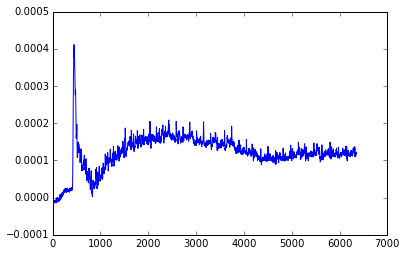

In [7]:
plt.plot(csc[35650:42000])

In [8]:
# Testing the median filter with some different window lengths.
wl = [71, 81, 91, 101, 111]

In [9]:
filtered = np.zeros((len(csc), len(wl)))

In [10]:
filtered = medfilt(csc, 91)

In [11]:
#count = 0
#for p in range(5):
#    count = count + 1
#    plt.figure(count, figsize=(30,10))
#    plt.plot(csc, color = 'cornflowerblue')
#    plt.plot(filtered[:,p], color = 'g', lw = 1.5)
#    plt.plot(csc-filtered[:,p], color = 'r')

In [12]:
#filtered = medfilt(csc, 91)

In [13]:
#plt.figure(figsize=(30,10))
#plt.axis([0,210000, -4000,14000])
#plt.plot(csc, color ='cornflowerblue')
#plt.plot(filtered, color = 'g')
#plt.plot(csc-filtered, color = 'r')

In [14]:
#filtered= csc - filtered

In [15]:
#plt.figure(figsize=(30,7))
#plt.plot(filtered[35650:42000], color = 'r')

In [16]:
#plt.figure(figsize=(30,7))
#plt.plot(csc[35650:42000], color = 'cornflowerblue')

## Thresholding

In [17]:
new_data = np.zeros(len(csc))
new_data = csc-filtered

In [18]:
# Declaring counter and and dead time.
# Dead time: if the threshold is reached, we wait 50 samples until the threshhold will be
# activated again
count  = -1
count2 = 0
timer = 0
# Dictionary with all thresholded shapes
thresholds = {}
# Get the value in the new_data array:
for i in new_data:
    # Increment the counter (counter = position in the array)
    count += 1
    # if the value is bigger then 800, the threshold is reached
    if i >= 0.00002:
        # check the thresholded window if some values are bigger then 2500.
        temp = [i for i in new_data[count -10 : count + 30] if i >= 0.00005 or i <= - 0.00003]
        # If no values are bigger then 2500 and the dead time is zero,
        # save the window in the dictionary 
        if len(temp) == 0 and timer == 0:
            # set the timer to 50, so 50 samples will be passed
            timer = 50
            # increment count2, for the array name
            count2 += 1
            thresholds["spike{0}".format(count2)] = new_data[count -10 : count + 30]
    elif timer > 0: 
        # Decrement the timer.
        timer -= 1
    else: 
        pass

In [19]:
# Transfrom the thresholded shpaes into a array
thresholds_array = np.zeros((40,len(thresholds)))
count = -1
for o in thresholds:
    count += 1
    thresholds_array[:,count] = thresholds[o]

## RBF (Radial basis function) interpolation

In [20]:
from scipy.interpolate import Rbf

In [21]:
x = np.arange(40)
x_new = np.linspace(0,40, 400)
thresholds_interp = np.zeros((len(x_new),len(thresholds_array[1,:])))
count = 0
# Interpolate the "Spikes" with a RBF function to generate more samples
# If all spikes get 10x more samples, the Dynamic Time Warping algorithm is 16x slower(see other notebooks)
for o in range(len(thresholds_array[1,:])):
    count += 1
    newfunc = Rbf(x, thresholds_array[:,o], function = 'cubic')
    thresholds_interp[:,o] = newfunc(x_new)

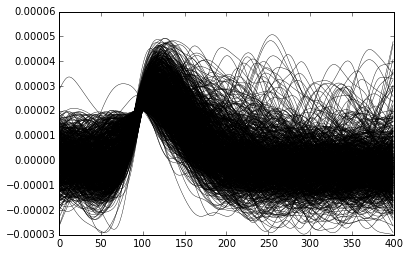

In [22]:
for o in range(len(thresholds_interp[0,:])):
    plt.plot( thresholds_interp[:,o], color = 'black', linewidth = 0.4)

## Scale and Normalize data

In [23]:
from sklearn import preprocessing
thresholds_scale = preprocessing.scale(thresholds_interp)

In [24]:
thresholds_norm = thresholds_scale/float(thresholds_scale.max())

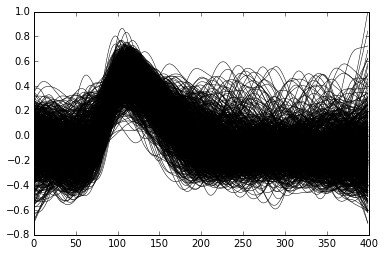

In [25]:
for o in range (len(thresholds_norm[1,:])):
    plt.plot(thresholds_norm[:,o], color = 'black', linewidth = 0.5)

## PCA ( Principal Component Analysis)

In [26]:
from sklearn.decomposition import PCA, FastICA

In [27]:
X_reduced = (PCA(n_components=1).fit_transform(thresholds_interp))
X_reduced2 = PCA(n_components=3).fit_transform(thresholds_interp)

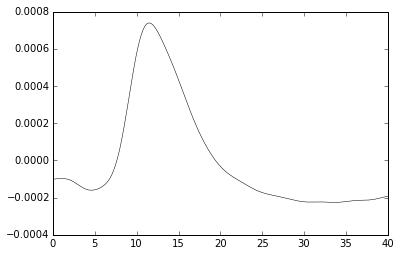

In [28]:
x = np.linspace(0,40,400)
plt.plot(x, X_reduced, color = 'black', linewidth = 0.5)